# Test notebook for pastas with Pest Solver

## Packages

In [1]:
from pathlib import Path

import pandas as pd
import pastas as ps

import pastas_plugins.pest as psp

## Load Data

In [2]:
head = (
    pd.read_csv(
        "https://raw.githubusercontent.com/pastas/pastas/master/doc/examples/data/head_nb1.csv",
        index_col="date",
        parse_dates=True,
    ).squeeze()
).iloc[-300:]
prec = pd.read_csv(
    "https://raw.githubusercontent.com/pastas/pastas/master/doc/examples/data/rain_nb1.csv",
    index_col="date",
    parse_dates=True,
).squeeze()
evap = pd.read_csv(
    "https://raw.githubusercontent.com/pastas/pastas/master/doc/examples/data/evap_nb1.csv",
    index_col="date",
    parse_dates=True,
).squeeze()
pex = (prec - evap).dropna().rename("PrecipitationExcess")

## Create Model

In [3]:
ml = ps.Model(head, name="PestGLM")
sm = ps.StressModel(
    pex, ps.Exponential(), name="pex", settings=ps.rcParams["timeseries"]["evap"]
)
ml.add_stressmodel(sm)

# Solve with Pest GLM

In [4]:
solver = psp.PestGlmSolver(
    exe_name="bin/pestpp-glm",
    model_ws=Path("pestf_glm/model"),
    temp_ws=Path("pestf_glm/temp"),
    noptmax=100,
)
ml.solve(solver=solver, report=False)

2024-07-30 17:05:19.298809 starting: opening PstFrom.log for logging
2024-07-30 17:05:19.299508 starting PstFrom process
2024-07-30 17:05:19.299615 starting: setting up dirs
2024-07-30 17:05:19.299702 starting: removing existing new_d '/home/martin/pastas-plugins/docs/examples/pestf_glm/temp'
2024-07-30 17:05:19.302150 finished: removing existing new_d '/home/martin/pastas-plugins/docs/examples/pestf_glm/temp' took: 0:00:00.002448
2024-07-30 17:05:19.302227 starting: copying original_d '/home/martin/pastas-plugins/docs/examples/pestf_glm/model' to new_d '/home/martin/pastas-plugins/docs/examples/pestf_glm/temp'
2024-07-30 17:05:19.304099 finished: copying original_d '/home/martin/pastas-plugins/docs/examples/pestf_glm/model' to new_d '/home/martin/pastas-plugins/docs/examples/pestf_glm/temp' took: 0:00:00.001872
2024-07-30 17:05:19.304516 finished: setting up dirs took: 0:00:00.004901
2024-07-30 17:05:19.334900 transform was not passed, setting default tranform to 'log'
2024-07-30 17:0

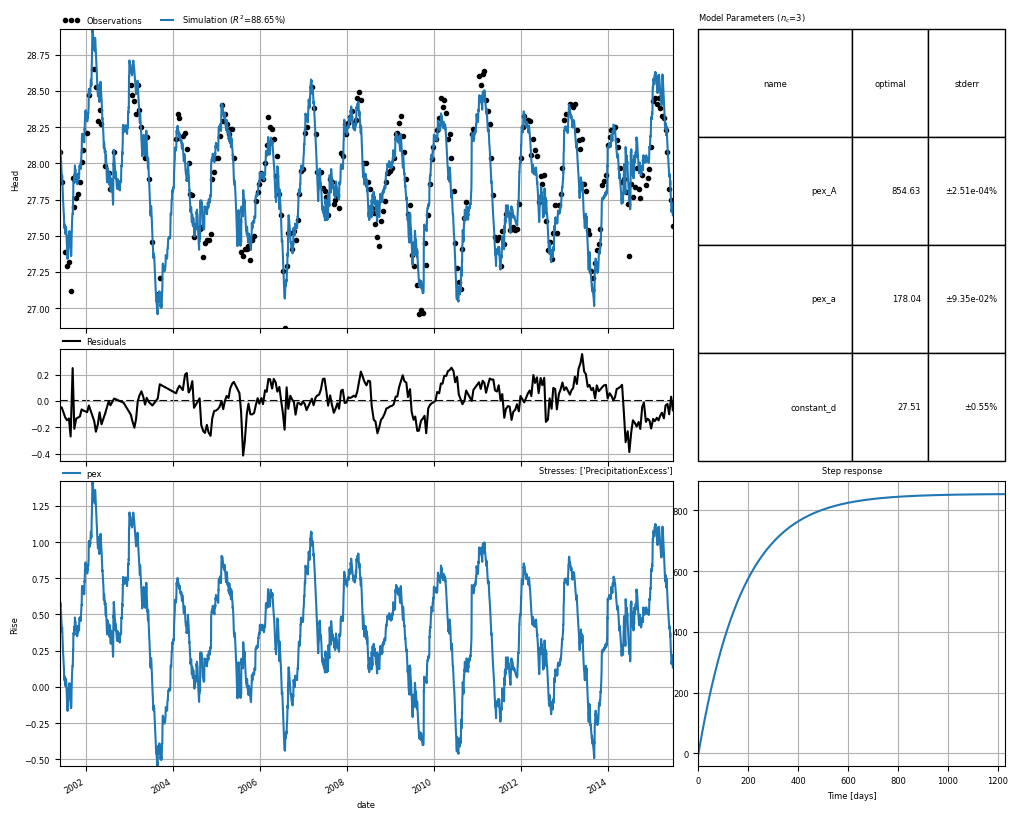

In [5]:
_ = ml.plots.results(stderr=True)

# Solve with Pest HP

In [8]:
ml_hp = ml.copy()
ml_hp.name = "PestHp"
control_data = dict(
    phiredstp=1e-3,
    nphistp=10,
    nphinored=10,
    relparstp=1e-3,
)

solver = psp.PestHpSolver(
    exe_name="bin/pest_hp",
    exe_agent="bin/agent_hp",
    model_ws=Path("pestf_hp/model"),
    temp_ws=Path("pestf_hp/temp"),
    noptmax=30,
    control_data=control_data,
)
ml_hp.solve(solver=solver, report=False)

2024-07-30 17:26:50.948111 starting: opening PstFrom.log for logging
2024-07-30 17:26:50.948848 starting PstFrom process
2024-07-30 17:26:50.948953 starting: setting up dirs
2024-07-30 17:26:50.949050 starting: removing existing new_d '/home/martin/pastas-plugins/docs/examples/pestf_hp/temp'
2024-07-30 17:26:50.951811 finished: removing existing new_d '/home/martin/pastas-plugins/docs/examples/pestf_hp/temp' took: 0:00:00.002761
2024-07-30 17:26:50.951874 starting: copying original_d '/home/martin/pastas-plugins/docs/examples/pestf_hp/model' to new_d '/home/martin/pastas-plugins/docs/examples/pestf_hp/temp'
2024-07-30 17:26:50.954017 finished: copying original_d '/home/martin/pastas-plugins/docs/examples/pestf_hp/model' to new_d '/home/martin/pastas-plugins/docs/examples/pestf_hp/temp' took: 0:00:00.002143
2024-07-30 17:26:50.954651 finished: setting up dirs took: 0:00:00.005698
2024-07-30 17:26:51.051140 transform was not passed, setting default tranform to 'log'
2024-07-30 17:26:51.0

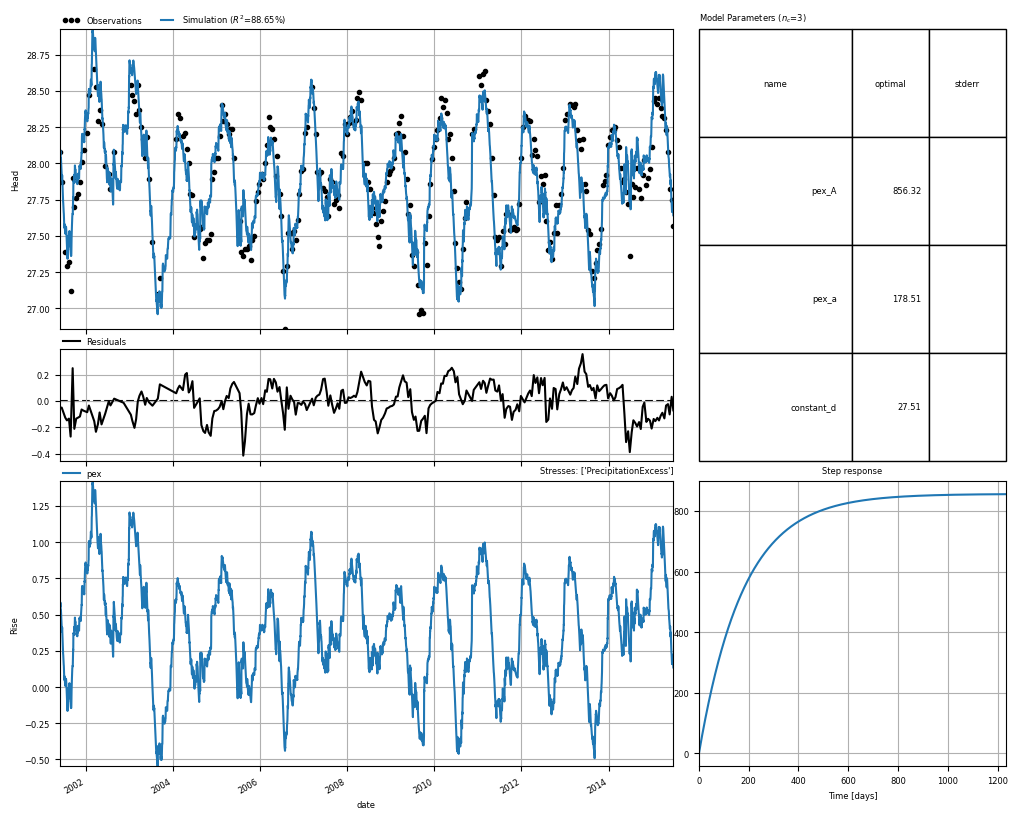

In [7]:
_ = ml_hp.plots.results(stderr=True)

# Solve with SciPy Least Squares

Fit report LeastSquares           Fit Statistics
nfev    26                     EVP         88.65
nobs    300                    R2           0.89
noise   False                  RMSE         0.13
tmin    2001-05-28 00:00:00    AICc     -1229.99
tmax    2015-06-28 00:00:00    BIC      -1218.96
freq    D                      Obj          2.44
warmup  3650 days 00:00:00     ___              
solver  LeastSquares           Interp.        No

Parameters (3 optimized)
               optimal     initial  vary
pex_A       850.895010  215.674528  True
pex_a       177.192164   10.000000  True
constant_d   27.508802   27.902000  True


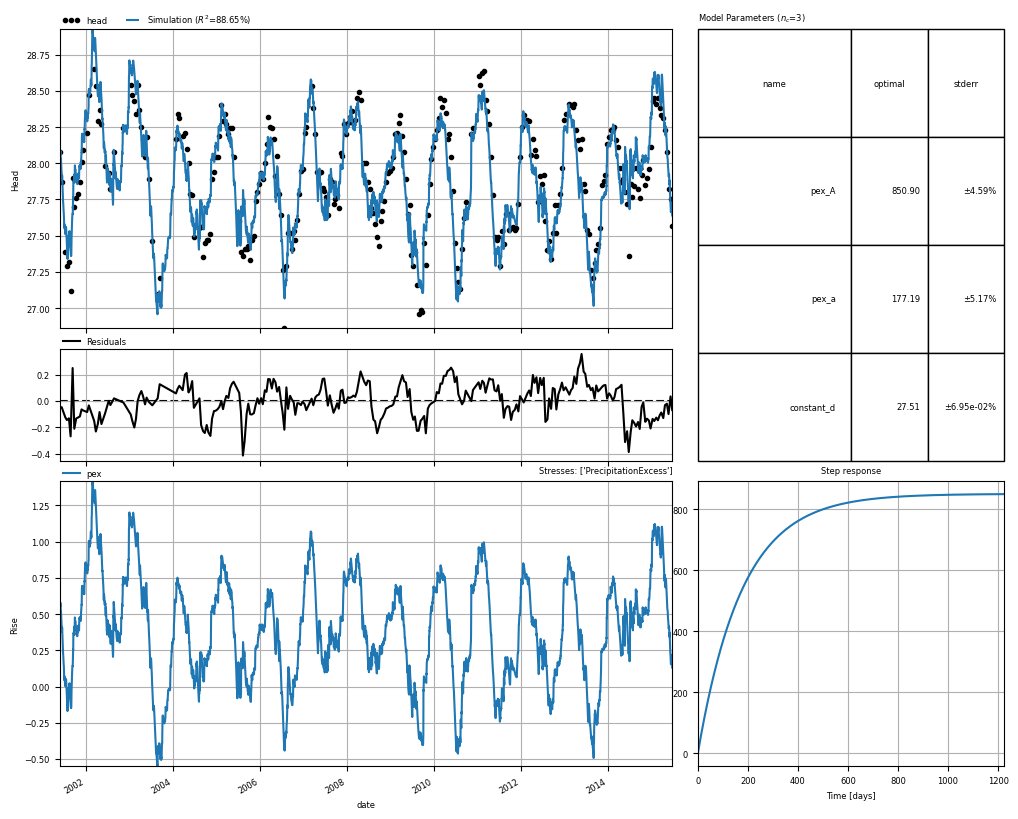

In [8]:
ml_ls = ml.copy()
ml_ls.name = "LeastSquares"
ml_ls.solve(solver=ps.LeastSquares())
_ = ml_ls.plots.results(stderr=True)

## Compare Results

### Plot

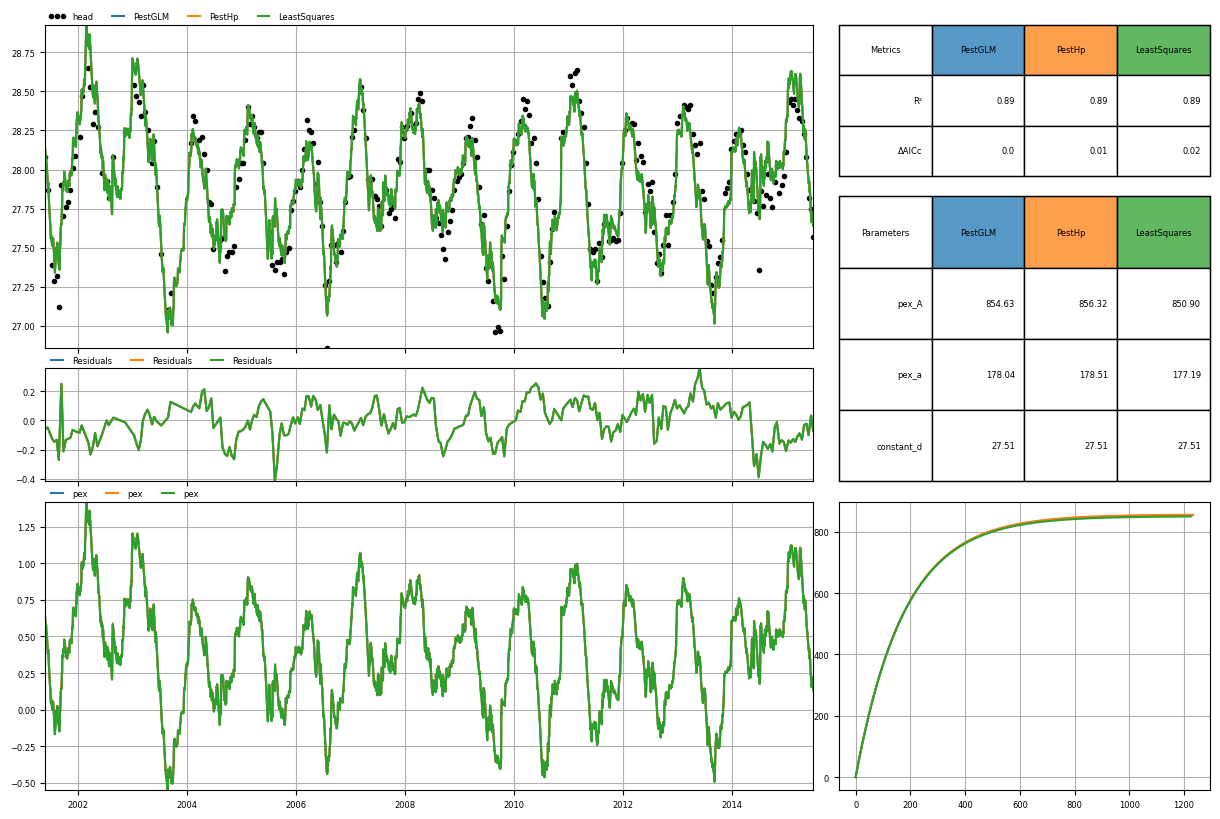

In [9]:
ps.plots.compare([ml, ml_hp, ml_ls], figsize=(12.0, 8.0));

### Fit metrics

In [10]:
pd.concat(
    [ml.stats.summary(), ml_hp.stats.summary(), ml_ls.stats.summary()],
    axis=1,
    keys=[ml.name, ml_hp.name, ml_ls.name],
).drop("rmsn")

,PestGLM,PestHp,LeastSquares
,Value,Value,Value
Statistic,,,
rmse,0.127436,0.127438,0.127439
sse,4.871948,4.872171,4.872242
mae,0.103352,0.103368,0.103322
nse,0.886460,0.886455,0.886453
evp,88.646019,88.645499,88.645334
rsq,0.886460,0.886455,0.886453
kge,0.917353,0.917294,0.916941
bic,-1218.975253,-1218.961510,-1218.957152


### Parameters (and stderr)

In [11]:
pd.concat(
    [
        ml.parameters.loc[:, ["optimal", "stderr"]],
        ml_hp.parameters.loc[:, ["optimal", "stderr"]],
        ml_ls.parameters.loc[:, ["optimal", "stderr"]],
    ],
    axis=1,
    keys=[ml.name, ml_hp.name, ml_ls.name],
)

PestGLM                PestHp        LeastSquares           
             optimal    stderr     optimal stderr      optimal     stderr
pex_A       854.6310  0.002147  856.324130    NaN   850.895010  39.066252
pex_a       178.0440  0.166463  178.514310    NaN   177.192164   9.168716
constant_d   27.5071  0.150136   27.506337    NaN    27.508802   0.019113

Standard error for the PestGlm optimization seems a bit too small. The PestHp does not have a standarderror, nor a covariance matrix (`pcov`). PestHp does have parameter sensitivy values but I'm not sure how to interpet those.

### Covariance matrices

In [12]:
pd.concat([ml.solver.pcov, ml_ls.solver.pcov], axis=1, keys=[ml.name, ml_ls.name])

PestGLM                      LeastSquares                       
               pex_A     pex_a constant_d        pex_A       pex_a constant_d
pex_A       0.000005 -0.000278  -0.000291  1526.172038  319.406440  -0.688453
pex_a      -0.000278  0.027710   0.022031   319.406440   84.065354  -0.143179
constant_d -0.000291  0.022031   0.022541    -0.688453   -0.143179   0.000365